In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from datetime import datetime
import shap
from sklearn.inspection import permutation_importance

In [18]:
exec(open("../../header.py").read())

# Import data

In [19]:
X = pd.read_csv(processed_root('cervical_cancer_risks/X.csv'))
y = pd.read_csv(processed_root('cervical_cancer_risks/y.csv'))

# Fit model

In [20]:
# fit RF
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X, y['Biopsy'])

RandomForestClassifier(n_estimators=500)

In [21]:
result = permutation_importance(rf, X, y, n_repeats=10,
                                random_state=42)

In [27]:
features = X.columns
features

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'],
      dtype='object')

In [24]:
perm_sorted_idx = result.importances_mean.argsort()

In [25]:
perm_sorted_idx

array([15, 27, 25, 24, 23, 21, 20, 18, 17, 14, 19, 11, 16, 13, 29, 31, 12,
       22, 26, 28, 30,  9,  4,  6, 10,  5,  7,  1,  2,  3,  0,  8])

In [43]:
pfi = pd.DataFrame({'Feature' : features,
              'PFI' : result.importances_mean}).\
        sort_values('PFI')

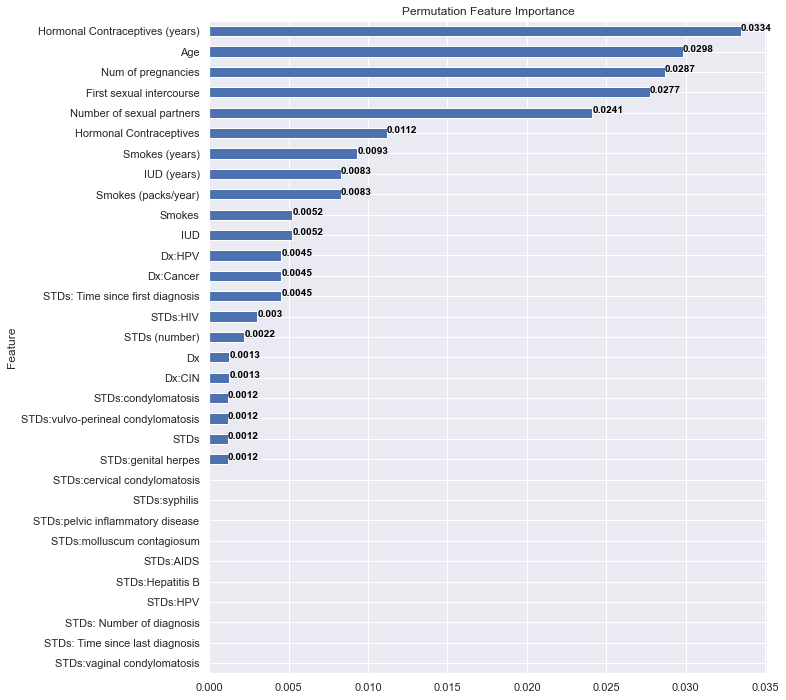

In [112]:
ax = pfi.plot.barh(x = 'Feature',
                     y = 'PFI',
                     legend = False,
                     figsize = (10,12))
ax.set_title('Permutation Feature Importance')

for i, v in enumerate(pfi.PFI):
    if v != 0:
        ax.text(v  , i, str(np.round(v,4)), color='black', fontweight='bold', size = 10)

Text(0.5, 1.0, 'Permutation Feature Importance')

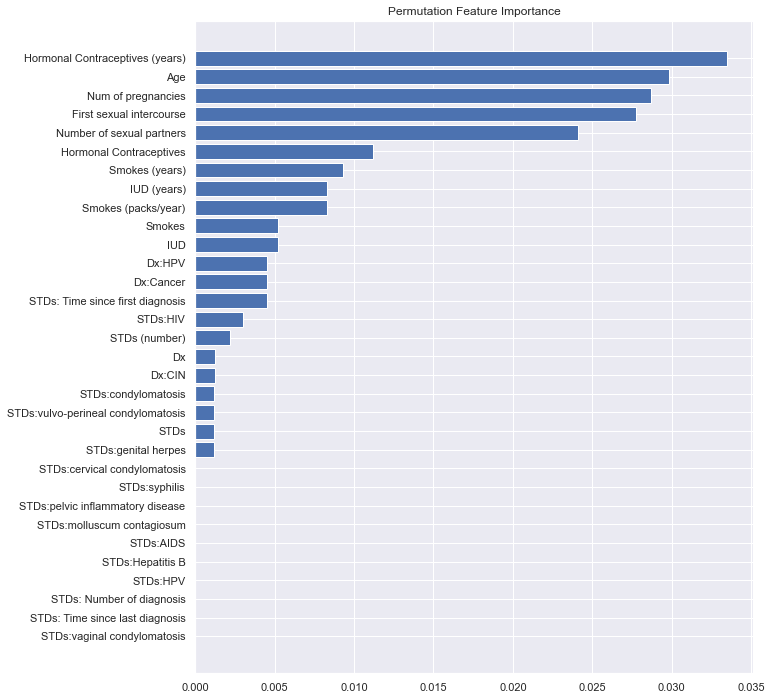

In [58]:
plt.figure(figsize=(10,12))
plt.barh(y = pfi.Feature, width = pfi.PFI)
plt.title('Permutation Feature Importance')

In [ ]:
import shap

class SHAP_FI():

    def __init__(self, model_type, seed_num = None, time = False, trace = False, max_display = 999):
        '''
        Instantiates the SHAP_FI class.
        @param model_type: Determine which version of SHAP to use
        @param seed_num : Random seed for reproducibility.
        @param time: Set time functionality for runtime.
        @param trace : Turn on/off trace messages for debugging.
        @param max_display : Set max display of features.
        @return ICE data (dataframe) with N observations.
        @examples
        SHAP_FI(420, time = True, trace = False, max_display = 10)
        '''
        self.model_type = model_type
        self.seed_num = seed_num
        self.trace = trace
        self.time = time
        self.max_display = max_display

    def fit(self, X, model):
        '''
        Uses Shapley values to explain any machine learning model.
        @param X : Covariate matrix.
        @param model : Model to interpet.
        '''
        self.features = X.columns

        start = datetime.now()

        if self.model_type == "linear":
            shap_values = shap.explainers\
                .Linear(model, X)\
                .shap_values(X)
        elif self.model_type == "tree":
            shap_values = shap.explainers\
                .Tree(model)\
                .shap_values(X)
        elif self.model_type == "neural-network":
            pass
        else:
            raise("Unrecognized model type.")

        end = datetime.now()

        # For classification, get the shap for the final class
        # hopefully last class = 1 but can't find relevant documentation
        if type(shap_values) == list:
            print(f"List of shap values. Taking 2nd element.")
            shap_values = shap_values[1]

        self.shap_values = shap_values.mean(axis = 0)

        if self.time:
            print(f"SHAP fits in {(end - start).total_seconds():.2f} seconds")

        return

    def plot(self, save_path = None):
        '''
        Plot the SHAP values.
        '''
        if self.shap is None:
            raise("Fit shap first.")

        fig = shap.summary_plot(self.shap_values, self.features, 
            plot_type = "bar", max_display = self.max_display)


        if save_path is not None:
            fig.savefig(save_path,
                        bbox_inches = 'tight',
                        pad_inches = 1)


    def feature_table(self):
        '''
        Return SHAP Value table.
        '''

        fi_df = pd.DataFrame({'Feature':self.features,
                              'Shapley Value': self.shap_values}).\
                sort_values('Shapley Value', ascending = False).\
                reset_index().\
                drop(['index'], axis=1)

        return fi_df  


# Shapley Values

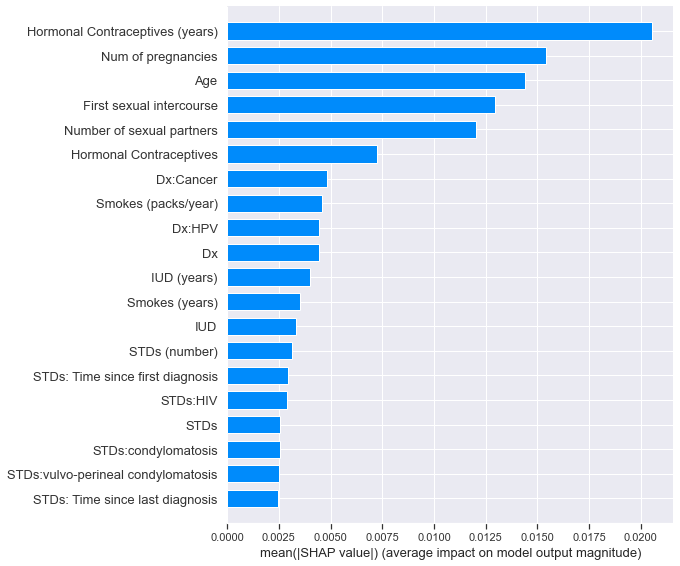

In [6]:
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values[1], X, plot_type = "bar")

In [7]:
features = X.columns
vals = np.abs(shap_values[1]).mean(0)
shap_vals = pd.DataFrame(list(zip(features, vals)), columns=['Feature','Shap_Value'])
shap_vals.sort_values(by=['Shap_Value'], ascending=False,inplace=True)
shap_vals.head(20)

Feature  Shap_Value
8      Hormonal Contraceptives (years)    0.020553
3                   Num of pregnancies    0.015403
0                                  Age    0.014408
2             First sexual intercourse    0.012936
1            Number of sexual partners    0.012022
7              Hormonal Contraceptives    0.007237
28                           Dx:Cancer    0.004818
6                  Smokes (packs/year)    0.004576
30                              Dx:HPV    0.004432
31                                  Dx    0.004420
10                         IUD (years)    0.004002
5                       Smokes (years)    0.003518
9                                  IUD    0.003331
12                       STDs (number)    0.003157
26    STDs: Time since first diagnosis    0.002933
22                            STDs:HIV    0.002879
11                                STDs    0.002559
13                 STDs:condylomatosis    0.002535
16  STDs:vulvo-perineal condylomatosis    0.002523
27     STDs: Time since last diagnosis    0.002451

# Age plot

In [8]:
exec(open("../../header.py").read())

In [9]:
ice = ICE("binary", trace = False)

In [10]:
ice.fit_single_feature(X, rf, "Age")

Fit Age in 1.85 seconds


Preprocessed data in 0.04 seconds
Plotted in 0.50 seconds


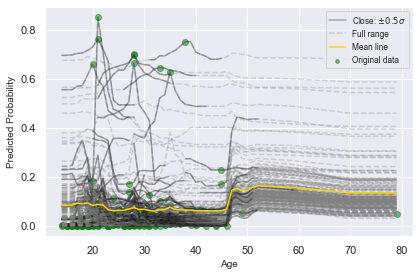

In [11]:
ice.ice_plot_single_feature('Age', plot_num = 200, mode = "ice", 
    save_path = results_root('cancer-dataset-production/age-ice.pdf'))

# Fit all

In [12]:
ice.fit(X, rf)

Fit Age in 1.66 seconds
Fit Number of sexual partners in 1.26 seconds
Fit First sexual intercourse in 1.43 seconds
Fit Num of pregnancies in 1.08 seconds
Fit Smokes in 0.92 seconds
Fit Smokes (years) in 1.41 seconds
Fit Smokes (packs/year) in 1.97 seconds
Fit Hormonal Contraceptives in 0.84 seconds
Fit Hormonal Contraceptives (years) in 1.63 seconds
Fit IUD in 0.96 seconds
Fit IUD (years) in 1.30 seconds
Fit STDs in 0.90 seconds
Fit STDs (number) in 0.99 seconds
Fit STDs:condylomatosis in 0.85 seconds
Fit STDs:cervical condylomatosis in 0.77 seconds
Fit STDs:vaginal condylomatosis in 0.92 seconds
Fit STDs:vulvo-perineal condylomatosis in 0.83 seconds
Fit STDs:syphilis in 0.93 seconds
Fit STDs:pelvic inflammatory disease in 0.82 seconds
Fit STDs:genital herpes in 0.84 seconds
Fit STDs:molluscum contagiosum in 0.97 seconds
Fit STDs:AIDS in 0.82 seconds
Fit STDs:HIV in 0.89 seconds
Fit STDs:Hepatitis B in 0.87 seconds
Fit STDs:HPV in 0.94 seconds
Fit STDs: Number of diagnosis in 0.91 seco

# Full ICE plot

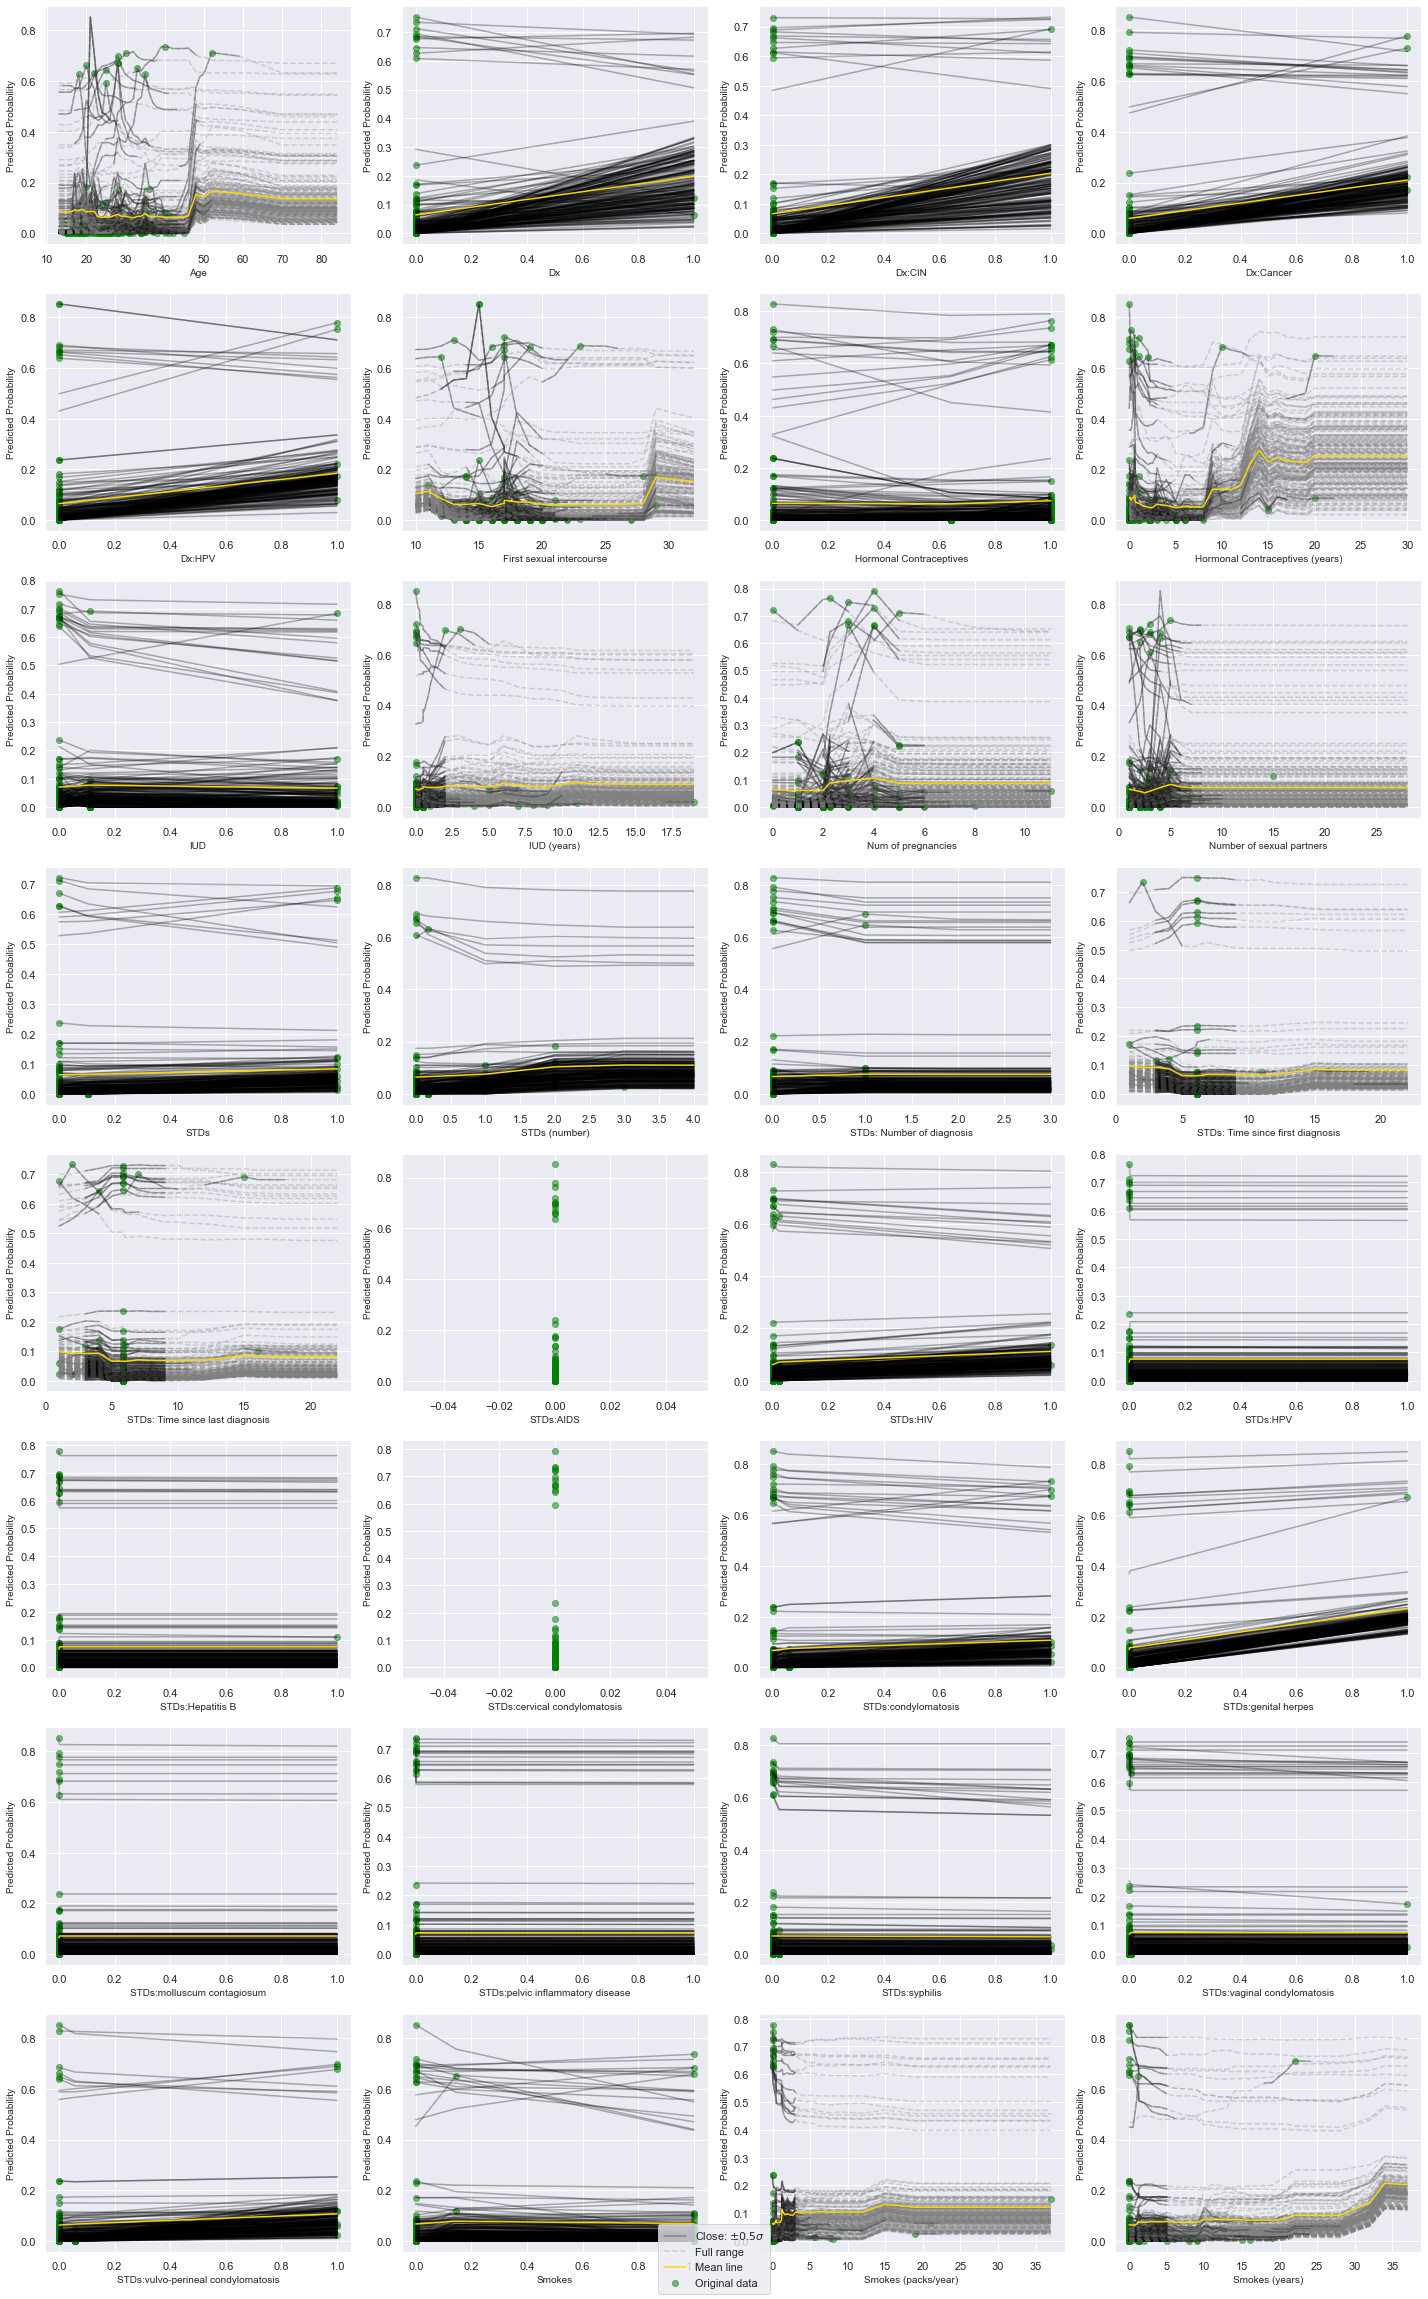

In [13]:
ice.ice_plot(save_path = results_root('cancer-dataset-production/all-ice-plots.pdf'),
             mode = 'ice', ncols = 4)
# ice.ice_plot(mode = "ice")

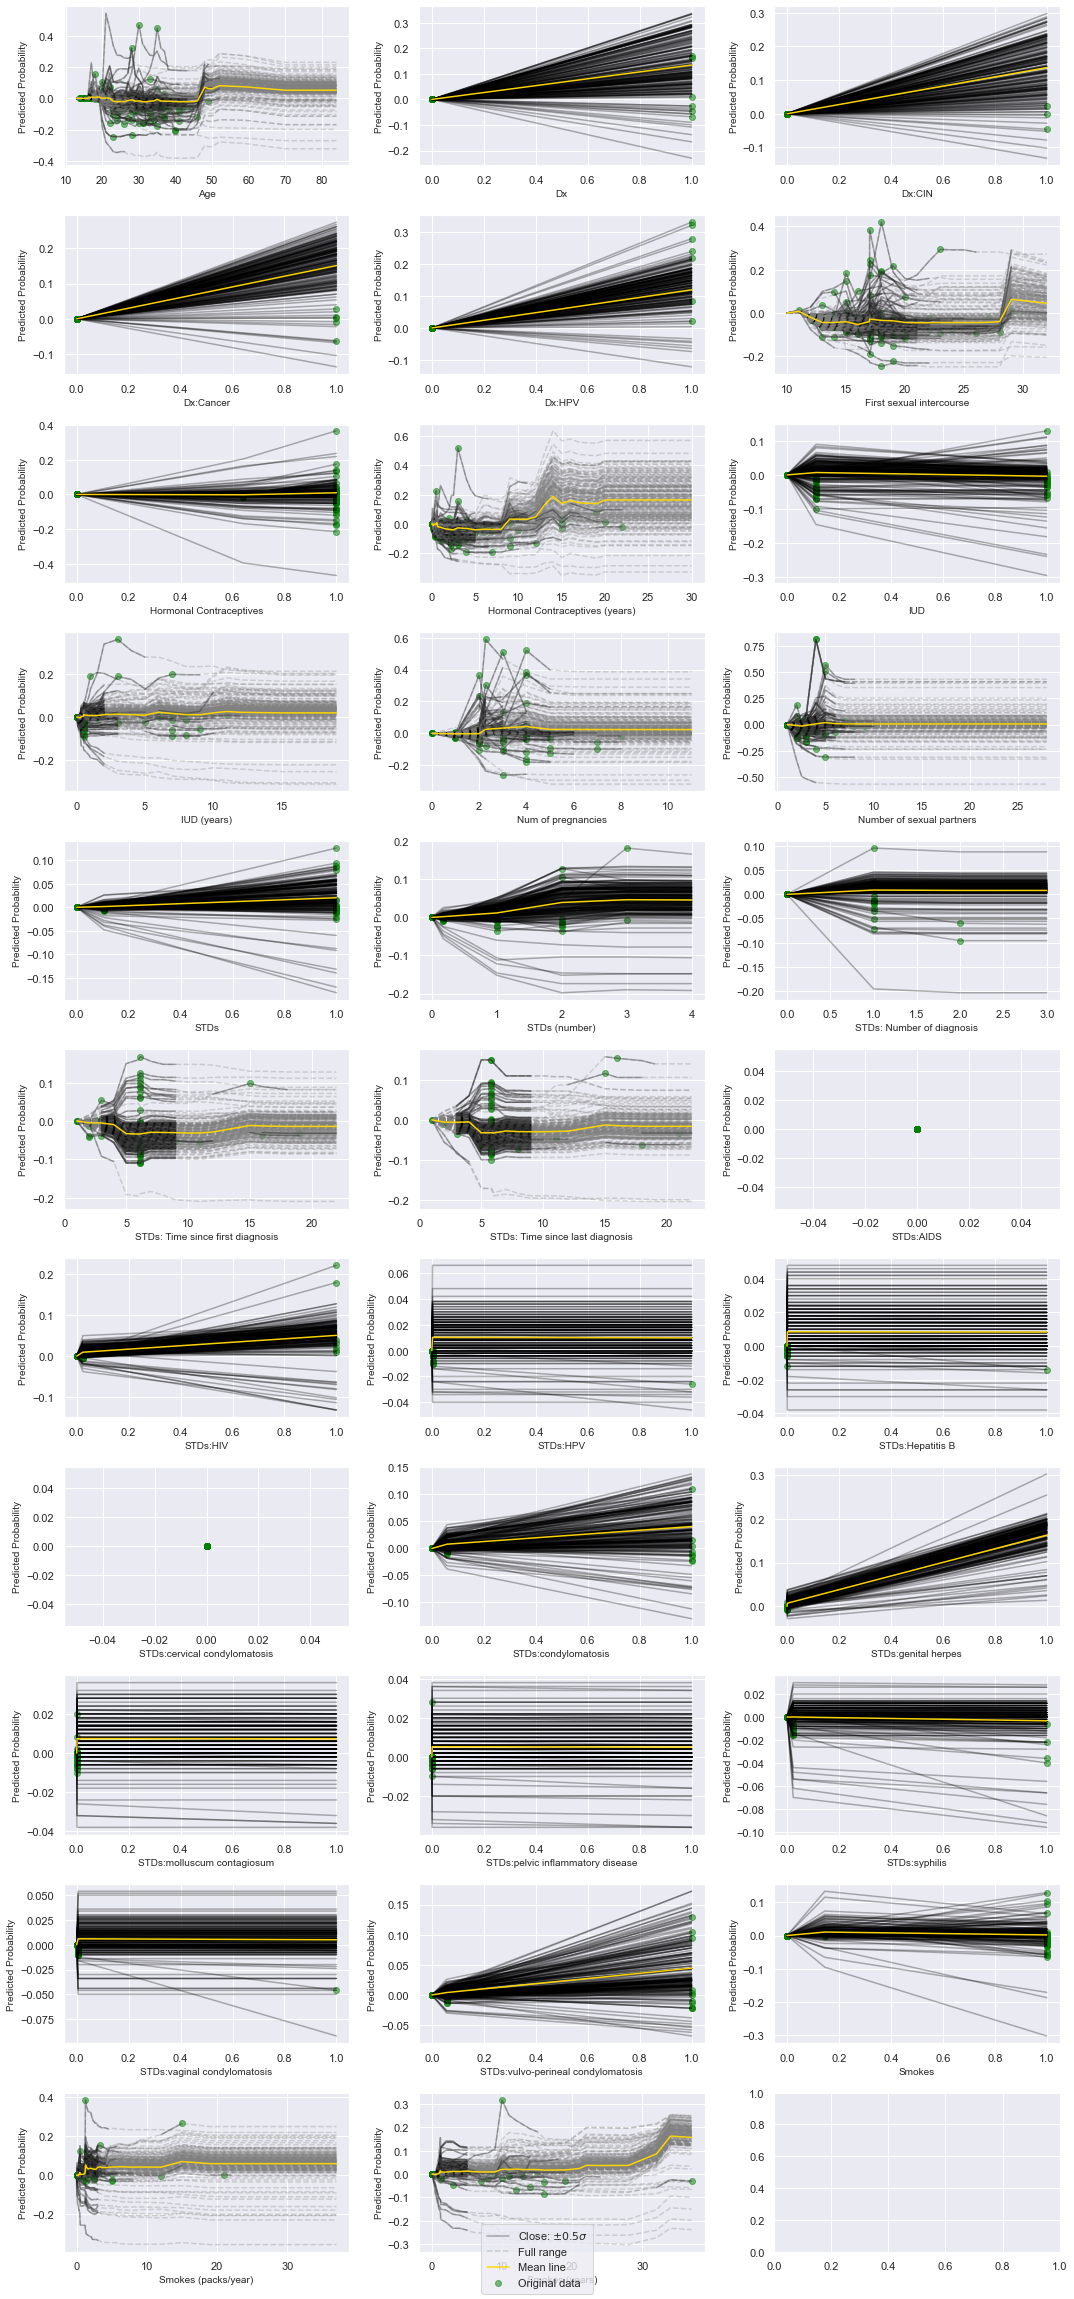

In [14]:
# ice.ice_plot(results_root("ice-plot-from-class/all_plots.pdf"))
ice.ice_plot(save_path = results_root('cancer-dataset-production/all-c-ice-plots.pdf'),
             mode = 'c-ice')

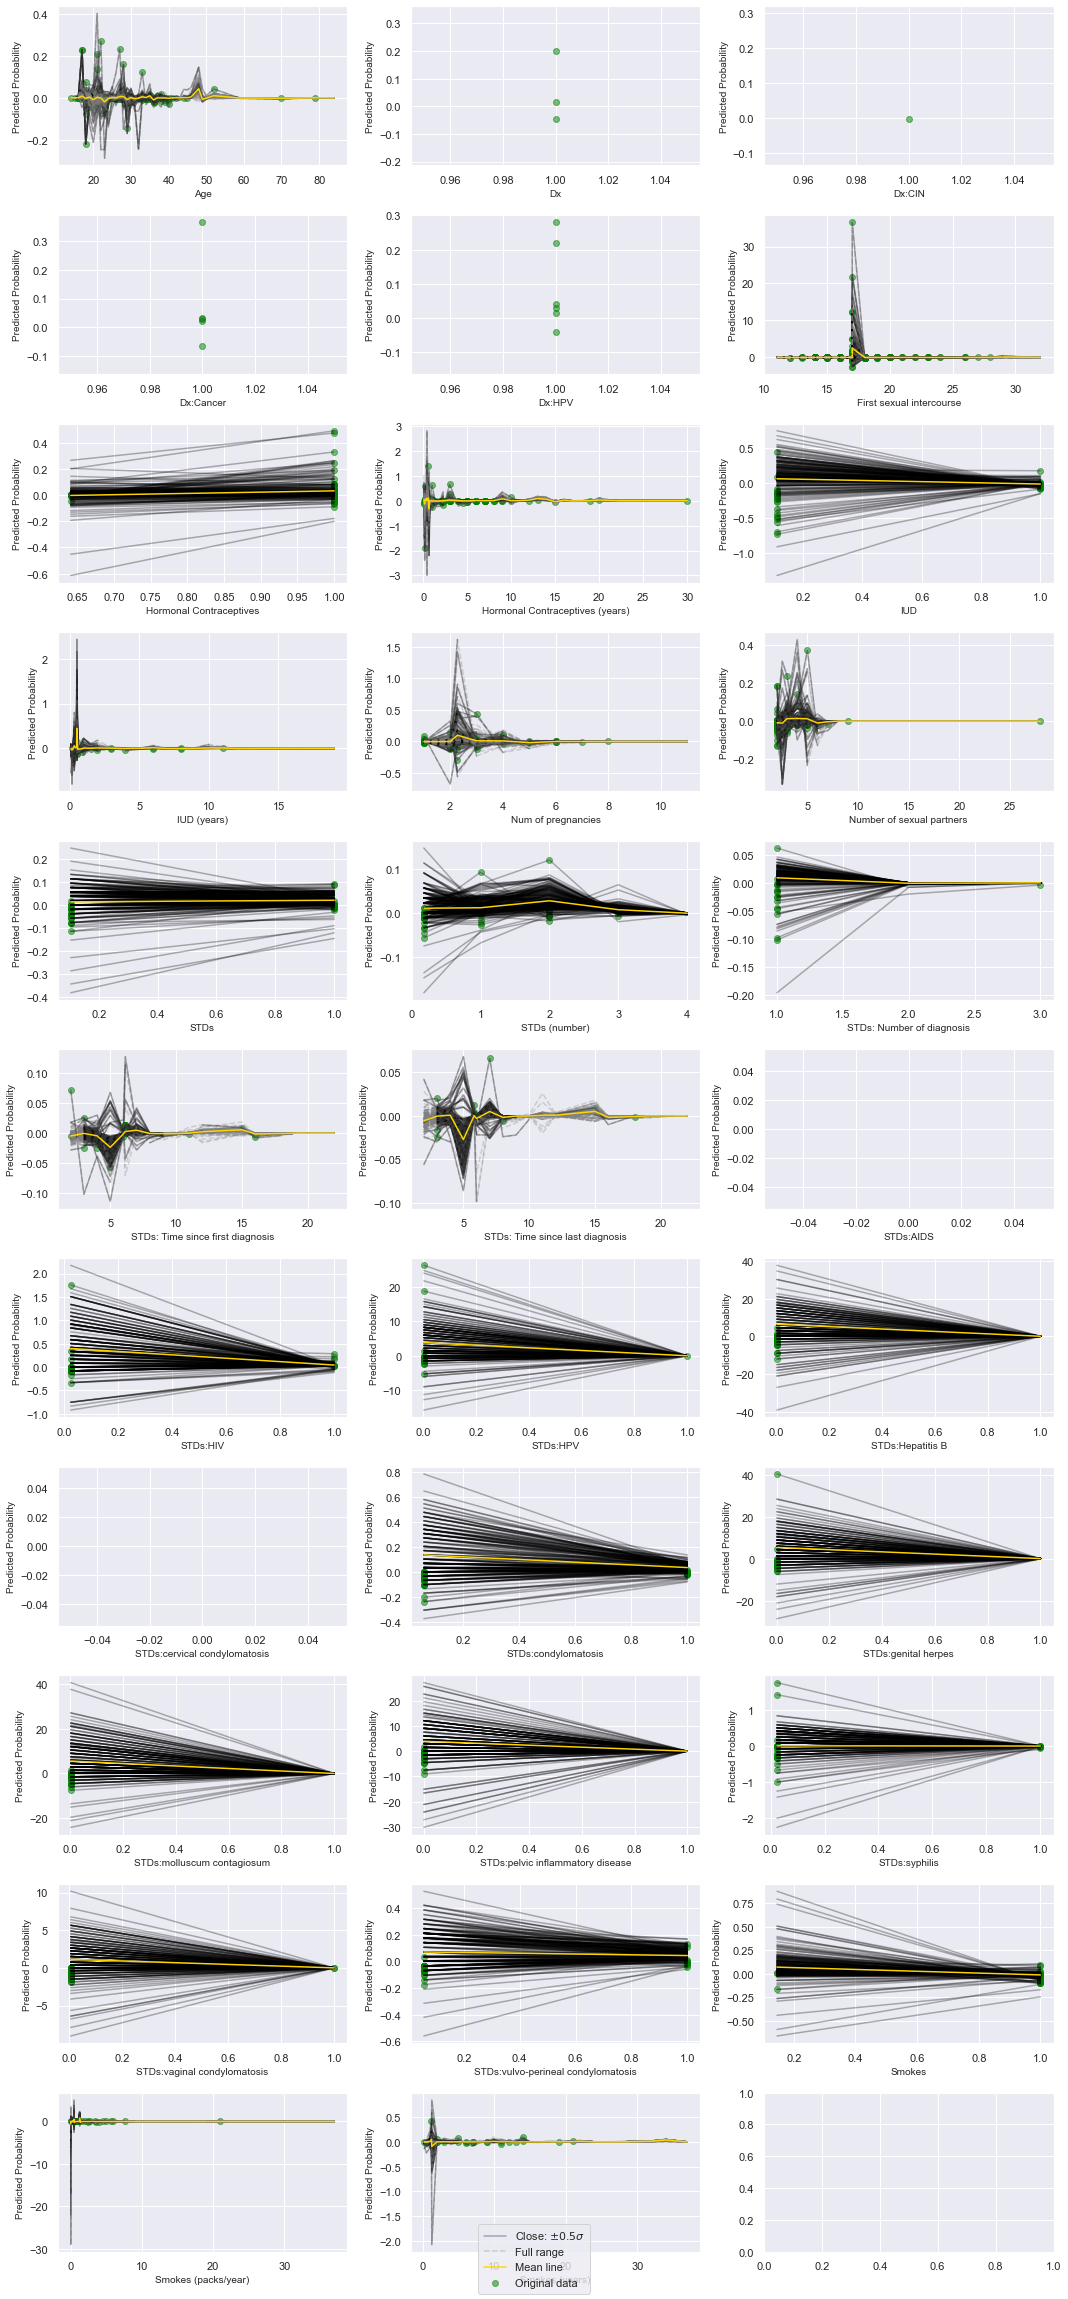

In [15]:
# ice.ice_plot(results_root("ice-plot-from-class/all_plots.pdf"))
ice.ice_plot(save_path = results_root('cancer-dataset-production/all-d-ice-plots.pdf'),
             mode = 'd-ice')

# Feature impact histogram

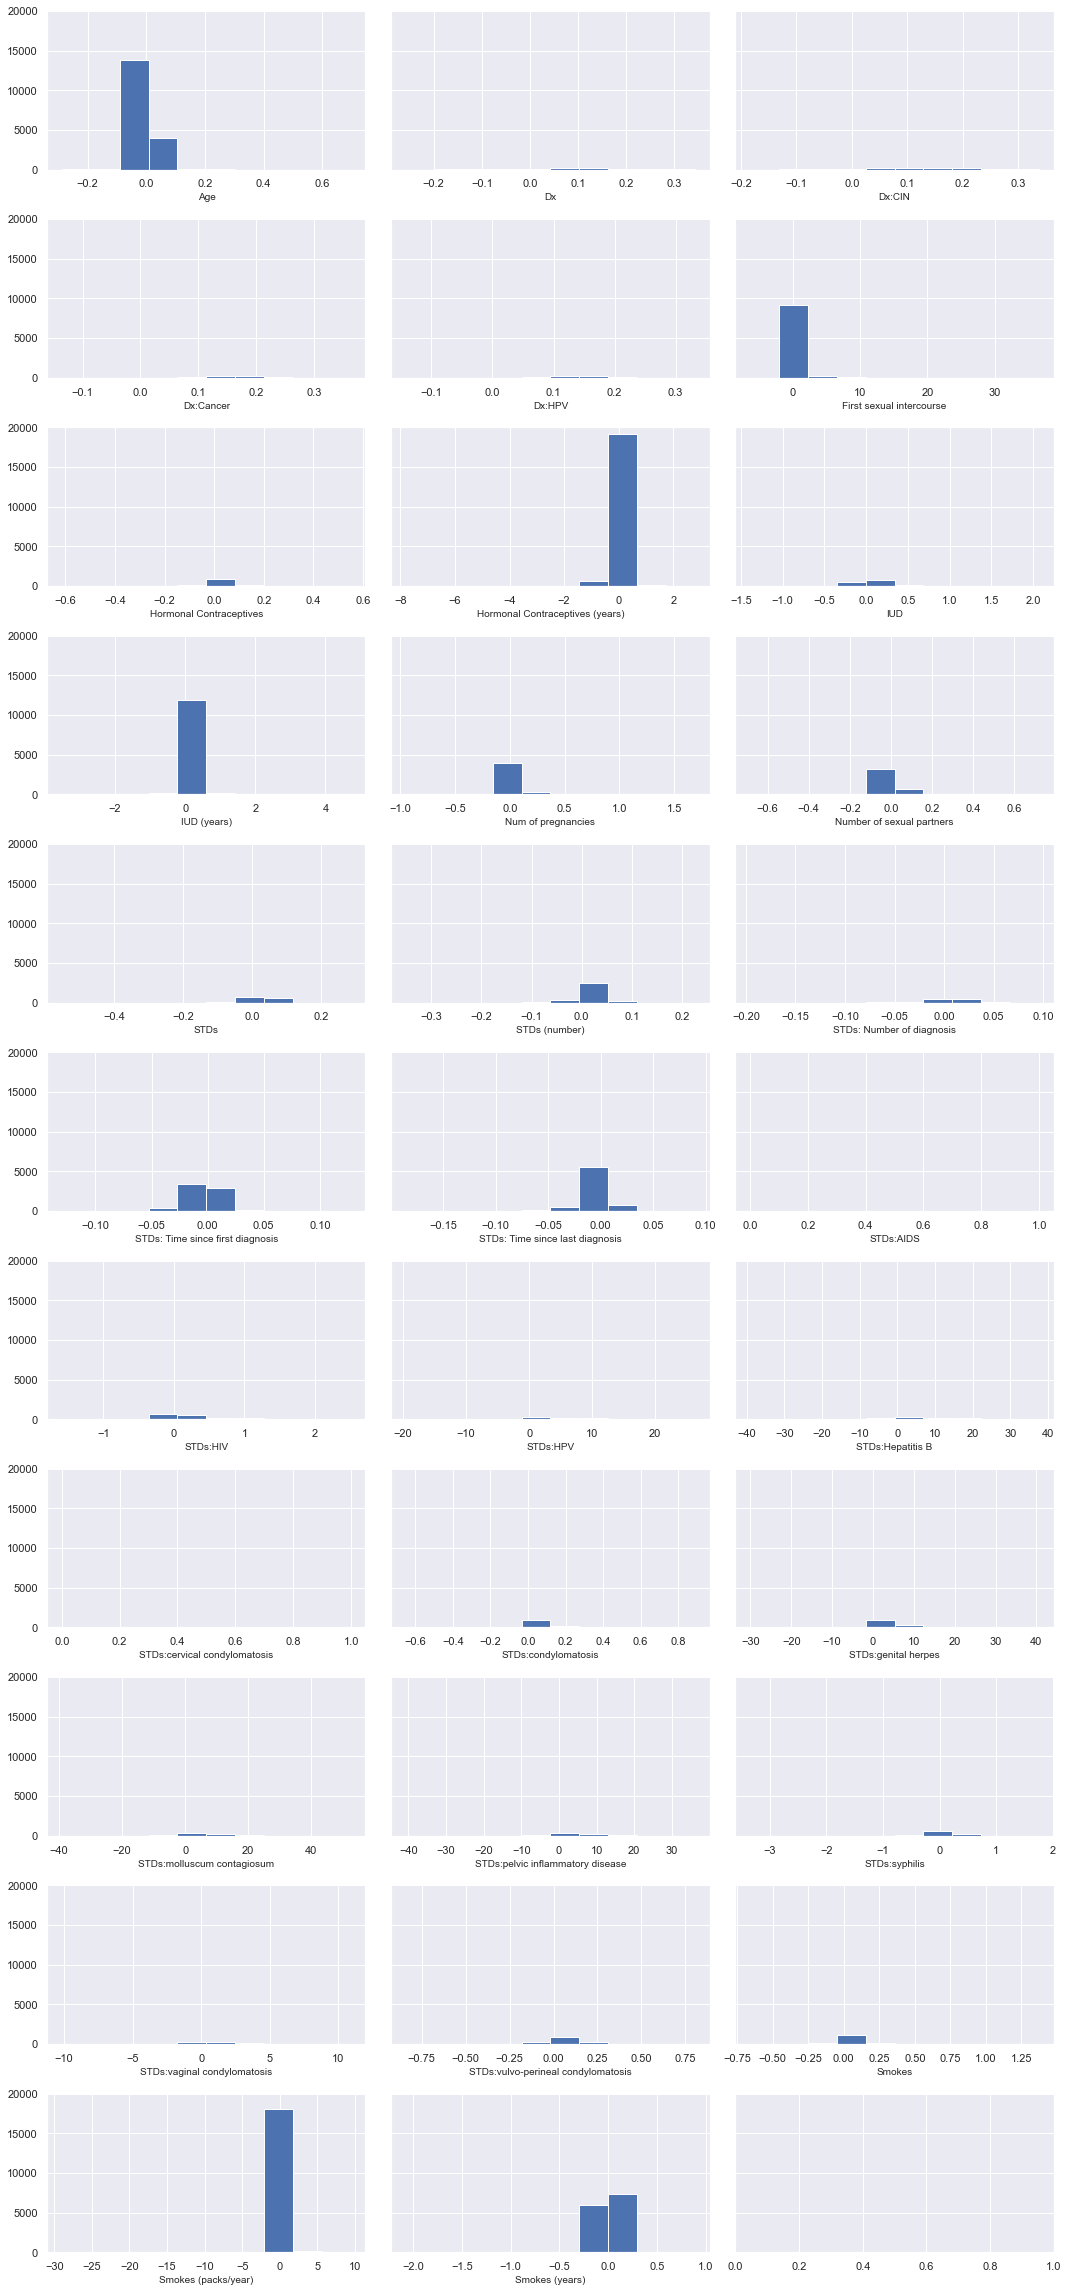

In [16]:
ice.feature_impact_hist(results_root("cancer-dataset-production/fi_histograms.pdf"))

# Feature impact vs Shapley values

In [20]:
ice.feature_impact_table()\
    .merge(shap_vals, how = "inner", on = "Feature")\
    .assign(Shap_Value_Normalized = lambda x:x['Shap_Value']*100/x['Shap_Value'].sum())\
    .assign(Difference = lambda x:x['Normalized Feature Impact'] - x['Shap_Value_Normalized'],
            in_dist_difference = lambda x:x['Normalized In-Dist Feature Impact'] - x['Shap_Value_Normalized'])\
    .rename({'in_dist_difference':'In-Dist Difference'}, axis = 1)\
    .round(2)\
    .sort_values('Difference', ascending = False)

Feature  Feature Impact  \
23                    STDs:Hepatitis B            2.09   
19                 STDs:genital herpes            1.93   
20          STDs:molluscum contagiosum            1.86   
18    STDs:pelvic inflammatory disease            1.54   
24                            STDs:HPV            1.28   
15         STDs:vaginal condylomatosis            0.50   
6                  Smokes (packs/year)            0.43   
21                           STDs:AIDS            0.00   
14        STDs:cervical condylomatosis            0.00   
17                       STDs:syphilis            0.08   
25           STDs: Number of diagnosis            0.01   
22                            STDs:HIV            0.12   
10                         IUD (years)            0.22   
29                              Dx:CIN            0.07   
4                               Smokes            0.03   
13                 STDs:condylomatosis            0.05   
16  STDs:vulvo-perineal condylomatosis            0.04   
5                       Smokes (years)            0.12   
27     STDs: Time since last diagnosis            0.03   
11                                STDs            0.02   
26    STDs: Time since first diagnosis            0.03   
9                                  IUD            0.06   
2             First sexual intercourse            0.90   
12                       STDs (number)            0.03   
31                                  Dx            0.07   
30                              Dx:HPV            0.06   
28                           Dx:Cancer            0.08   
7              Hormonal Contraceptives            0.02   
1            Number of sexual partners            0.09   
0                                  Age            0.12   
3                   Num of pregnancies            0.08   
8      Hormonal Contraceptives (years)            0.45   

    In-Dist Feature Impact  Normalized Feature Impact  \
23                    1.86                      16.85   
19                    1.69                      15.60   
20                    1.65                      14.98   
18                    1.37                      12.43   
24                    1.14                      10.33   
15                    0.44                       4.04   
6                     0.45                       3.46   
21                    0.00                       0.00   
14                    0.00                       0.00   
17                    0.07                       0.67   
25                    0.01                       0.06   
22                    0.10                       1.00   
10                    0.25                       1.74   
29                    0.01                       0.57   
4                     0.02                       0.24   
13                    0.04                       0.41   
16                    0.03                       0.34   
5                     0.13                       0.99   
27                    0.03                       0.21   
11                    0.01                       0.16   
26                    0.03                       0.21   
9                     0.05                       0.47   
2                     0.98                       7.23   
12                    0.03                       0.22   
31                    0.02                       0.59   
30                    0.01                       0.51   
28                    0.02                       0.63   
7                     0.01                       0.13   
1                     0.09                       0.73   
0                     0.12                       0.94   
3                     0.09                       0.67   
8                     0.47                       3.59   

    Normalized In-Dist Feature Impact  Shap_Value  Shap_Value_Normalized  \
23                              16.56        0.00                   0.36   
19                              15.10        0.00                   0.74   
20    

# Feature impact vs random forest feature importance

In [ ]:
b = pd.DataFrame({'Feature':X.columns, 
              'RF Feature Importance':rf.feature_importances_*100})\
    .round(3)

In [ ]:
a = ice.feature_impact_table()\
    .merge(b, how = "inner", on = "Feature")\
    .assign(Difference = lambda x:x['Normalized Feature Impact'] - x['RF Feature Importance'],
            in_dist_difference = lambda x:x['Normalized In-Dist Feature Impact'] - x['RF Feature Importance'])\
    .rename({'in_dist_difference':'In-Dist Difference'}, axis = 1)\
    .round(2)\
    .sort_values('Difference', ascending = False)\
    .loc[:,['Feature', 'Feature Impact', 'In-Dist Feature Impact', 'Normalized Feature Impact', 'RF Feature Importance', 'Difference']]

In [ ]:
a.sort_values('RF Feature Importance', ascending = False)

In [ ]:
print(a.to_latex(index = False,
                 column_format = 'p{5cm}c{1cm}c{1cm}c{1cm}c{1cm}c{1cm}',
                 label = "fig:cancer-fi-table",
                 caption = "Feature impact table for all features in cervical cancer dataset.",
                ))

In [ ]:
print(a\
      .assign(abs_diff = lambda x:np.abs(x['Difference']))\
      .sort_values('abs_diff', ascending = False)\
      .drop('abs_diff', axis = 1)\
      .head(5)\
      .to_latex(index = False,
                 column_format = 'p{5cm}c{1cm}c{1cm}c{1cm}c{1cm}c{1cm}',
                 label = "fig:cancer-fi-table-top-5",
                 caption = "Feature impact table for features in cervical cancer dataset with largest difference between feature importance and impact.",
                ))

In [21]:
from sklearn.datasets import make_classification

In [23]:
X, y = make_classification(n_samples = 100, n_features = 50, n_classes = 2)

In [24]:
rf_test = RandomForestClassifier()

In [25]:
rf_test.fit(X,y)

RandomForestClassifier()

In [26]:
rf_test.score(X,y)

1.0

In [30]:
ice.fit(pd.DataFrame(X), rf_test)

TypeError: can only concatenate str (not "int") to str